# PDE-FIND for identifying diffusion from a random walk

Samuel Rudy, 2016

In this notebook we demonstrate the method for finding the PDE associated with the distribution of a particle with stochastic trajectory.  The diffusion equation is derived from a random walk, meant to be discrete measurements of Brownian motion.  A time series of length $10^6$ is generated with $x_{n+1} \sim \mathcal{N}(x_n, dt)$.  From this we approximate the distribution function of the future potision of the trajectory and fit to a PDE.  In theory, we expect $f_t = 0.5f_{xx}$.  The algorithm achieves the correct PDE with parameter error $\sim 10^{-3}$.  

A second time series is used to try to identify the advection diffusion equation.  This time, $x_{n+1} \sim \mathcal{N}(x_n + c dt, dt)$.  We expect the distribution function to follow $f_t = 0.5f_{xx} - c f_x$.  Trying a few different sparsity promoting methods yields different results, with  greedy algorithm being the only one that works.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)
import numpy as np
from PDE_FIND import *
labelfontsize = 16; tickfontsize = 16; titlefontsize = 18

Populating the interactive namespace from numpy and matplotlib


## Data Collection

First generate a dataset.  This is just a bunch of points where each is drawn from a normal distribution centered on it's predecesor.

(array([ -50.,    0.,   50.,  100.,  150.,  200.]),
 <a list of 6 Text yticklabel objects>)

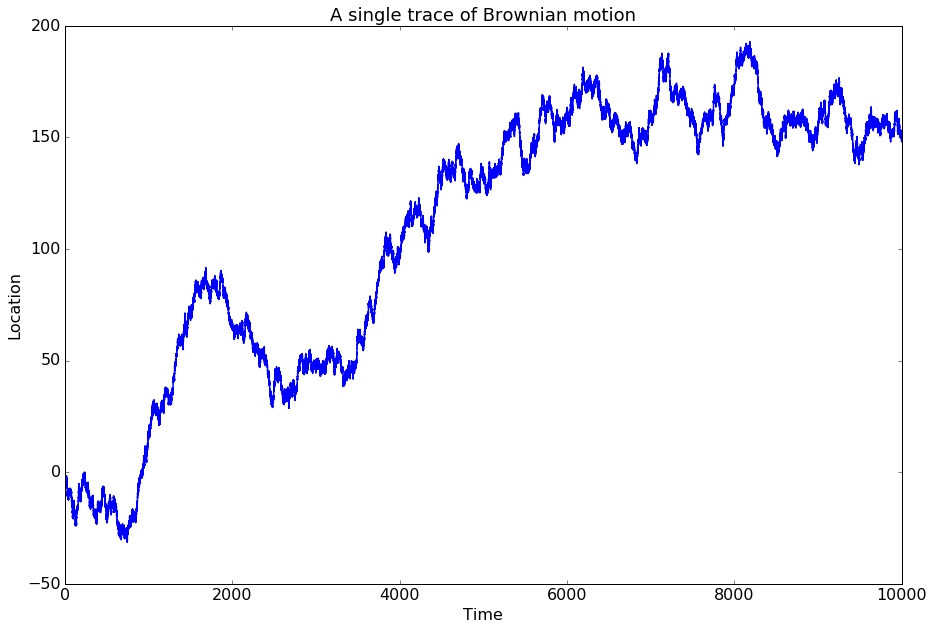

In [2]:
length = 10**6
dt = 0.01
numpy.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length))
    
plot(dt*np.arange(length),pos, linewidth = 1.5)
xlabel('Time', fontsize = labelfontsize)
ylabel('Location', fontsize = labelfontsize)
title('A single trace of Brownian motion', fontsize = titlefontsize)
xticks(fontsize = tickfontsize); yticks(fontsize = tickfontsize)

## Finding the distribution function

Now we take the single trajectory, split it up into many smaller ones, and create a histogram to approximate the distribution funciton.  The histograms clearly show a normal distribution spreading out as time goes on.

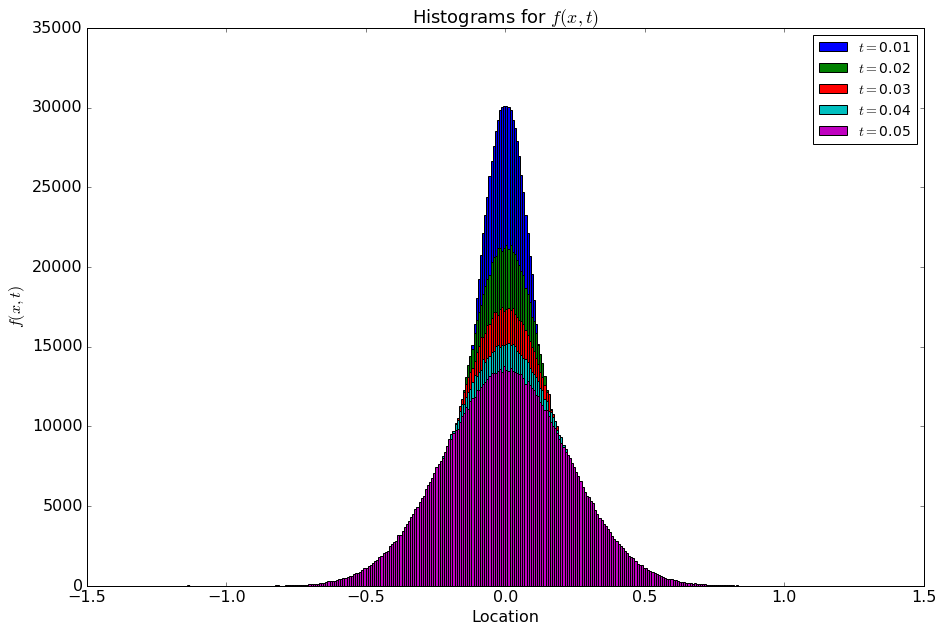

In [3]:
pylab.rcParams['figure.figsize'] = (15,10)

P = {}
M = 0

m = 5
n = 300

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = linspace(0,dt*(m-1),m)
U = np.zeros((n,m))
for i in range(m):
    U[:,i] = hist(P[i],bins,label=r'$t = $' + str(i*dt+dt))[0]/float(dx*(len(pos)-m))
    
xlabel('Location', fontsize = labelfontsize)
ylabel(r'$f(x,t)$', fontsize = labelfontsize)
title(r'Histograms for $f(x,t)$', fontsize = titlefontsize)
xticks(fontsize = tickfontsize); yticks(fontsize = tickfontsize)
legend(loc = 'upper right', fontsize = 14)

## Using PDE-FIND to identify the diffusion equation

Finally we derive a PDE for the distribution using PDE-FIND.  For simple Brownian motion, it works quite well.  Below, we show that an added diffusion term makes it more difficult to correctly idenitify the dynamics.

In [4]:
Ut,R,rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', deg_x = 4)
w = TrainSTRidge(R, Ut, 10**-5, 25, normalize = 2)

print "Candidate functions for PDE"
for func in ['1'] + rhs_des[1:]: print func

print "\nPDE derived from data:"
print_pde(w, rhs_des)

Candidate functions for PDE
1
u
u^2
u^3
u_{x}
uu_{x}
u^2u_{x}
u^3u_{x}
u_{xx}
uu_{xx}
u^2u_{xx}
u^3u_{xx}
u_{xxx}
uu_{xxx}
u^2u_{xxx}
u^3u_{xxx}

PDE derived from data:
u_t = (0.498425 +0.000000i)u_{xx}
   


## Advection diffusion from a biased random walk

Now we'll try adding an advection term.  Looking at the histograms, we see that they are similar but the means appear to be moving to the right due to the advection term.

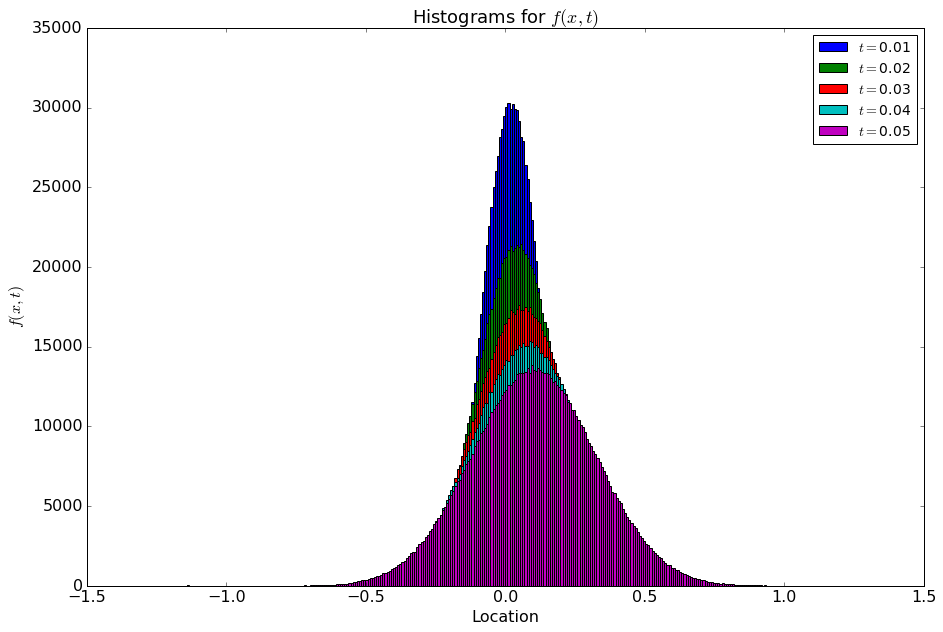

In [5]:
length = 10**6
dt = 0.01
c = 2
numpy.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length)) + c*dt*np.arange(length)

P = {}
M = 0

m = 5
n = 300

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = linspace(0,dt*(m-1),m)
U = np.zeros((n,m))
for i in range(m):
    U[:,i] = hist(P[i],bins,label=r'$t = $' + str(i*dt+dt))[0]/float(dx*(len(pos)-m))
    
xlabel('Location', fontsize = labelfontsize)
ylabel(r'$f(x,t)$', fontsize = labelfontsize)
title(r'Histograms for $f(x,t)$', fontsize = titlefontsize)
xticks(fontsize = tickfontsize); yticks(fontsize = tickfontsize)
legend(loc = 'upper right', fontsize = 14)

Now try to identify the dynamics.  This is an example of how different sparsity promoting regression methods can behave differently.  Here the STRidge algorithm works only when the data is not normalized.  The greedy algorithm seems to be fairly robust to small changes, and Lasso works with some tuning (maybe only because we know the right answer).  Normally STRidge with $L^2$ normalization outperforms all the rest.

In [6]:
Ut,R,rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', deg_x = 4)

print "Candidate functions for PDE"
for func in ['1'] + rhs_des[1:]: print func

print "\nPDE derived with STRidge and L^2 normalization (wrong PDE...)"
w = TrainSTRidge(R, Ut, 10**-5, 25, normalize = 2)
print_pde(w, rhs_des)

print "PDE derived with STRidge without normalization (correct PDE!)"
w = TrainSTRidge(R, Ut, 10**-5*length, 0.1, normalize = 0)
print_pde(w, rhs_des)

print "PDE derived with greedy algorithm (correct PDE!)"
w = FoBaGreedy(R, Ut,3)
print_pde(w, rhs_des)

print "PDE derived with Lasso (correct PDE!)"
w = Lasso(R, Ut,300)
print_pde(w, rhs_des)
# This last one is surprising since Lasso normally doesn't do as well as the others

Candidate functions for PDE
1
u
u^2
u^3
u_{x}
uu_{x}
u^2u_{x}
u^3u_{x}
u_{xx}
uu_{xx}
u^2u_{xx}
u^3u_{xx}
u_{xxx}
uu_{xxx}
u^2u_{xxx}
u^3u_{xxx}

PDE derived with STRidge and L^2 normalization (wrong PDE...)
u_t = (0.500872 +0.000000i)u_{xx}
   
PDE derived with STRidge without normalization (correct PDE!)
u_t = (-2.000641 +0.000000i)u_{x}
    + (0.503582 +0.000000i)u_{xx}
   
PDE derived with greedy algorithm (correct PDE!)
u_t = (-2.000641 +0.000000i)u_{x}
    + (0.503582 +0.000000i)u_{xx}
   
PDE derived with Lasso (correct PDE!)
u_t = (-2.000641 +0.000000i)u_{x}
    + (0.503582 +0.000000i)u_{xx}
   
